# GAIT RECOGNITION

## 1. Data preparation

Let's create some directories

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import shutil

In [4]:
partA = 'DatasetB-1/video/'
partB = 'DatasetB-2/video/'
silhouettes_dir = 'silhouettes_Unet22K/'
# define the path of CASIA directory
CASIA_dir = '/home/israel/Downloads/CASIA/'
conditions = np.array(['bg-01','bg-02','cl-01','cl-02','nm-01','nm-02','nm-03','nm-04','nm-05','nm-06'])
views = ['090']
subjects = 50

In [5]:
# plt.figure(figsize=(20, 10))
# plt.subplot(131); plt.imshow(bkgnd[:,:,::-1]); 
# plt.subplot(132); plt.imshow(fr_cap[:,:,::-1]);
def create_dir(folder, force=True, verbose=False):
    '''   Create a directory if it doesn't exist  '''
    try:
        os.makedirs(folder)
        if verbose: print('Directory {} created succesfully.'.format(folder))   
    except:
        if force:
            if verbose: print('{} already exists. Creating a new one'.format(folder))
            shutil.rmtree(folder)
            os.makedirs(folder)
        else:
            if verbose: print('{} already exists.'.format(folder))
            pass
def get_roi(bkgnd, frgnd, margin = 10):
    height, width, _ = frgnd.shape
    bk_gray = cv2.cvtColor(bkgnd, cv2.COLOR_BGR2HSV)
    fr_gray = cv2.cvtColor(frgnd, cv2.COLOR_BGR2HSV)

    diff = cv2.subtract(bk_gray[:,:,2],fr_gray[:,:,2])
    _, diff = cv2.threshold(diff, 30, 255, cv2.THRESH_BINARY)
    if diff.sum() > 400000:
        col1, row1, col2, row2 = cv2.boundingRect(diff)
        x = col1 - margin if col1 - margin >= 0 else 0
        y = row1 - margin if row1 - margin >= 0 else 0
        w = col2 + 2*margin if col2 + 2*margin <= width else width
        h = row2 + 2*margin if row2 + 2*margin <= height else height
        return (frgnd[y:y+h,x:x+w], [x, y, w, h])
    else:
        return None

In [6]:
import tensorflow as tf
# from tensorflow_examples.models.pix2pix import pix2pix

AUTOTUNE = tf.data.experimental.AUTOTUNE
import matplotlib.pyplot as plt
import numpy as np
import os

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

In [7]:
import sys
import cv2
import time
import colorsys
import random
# import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [8]:
def random_colors(N, bright=True):
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    return colors


def apply_mask(image, mask, color, alpha=0.5):
#     if image.shape[:2] != mask.shape:
#         h, w, _ = image.shape
#         mask = cv2.resize(mask, (w, h), cv2.INTER_LINEAR)
    """Apply the given mask to the image"""
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image

In [9]:
name = '128x128unet_acc_0.9451_loss_0.0845_val-acc_0.9457_val-loss_0.0826_0.22M_24-10-21-DB_UCB300_Epochs_10x1E-4_5x1E-5'
model = tf.keras.models.load_model(f'../models/BioSmart/{name}')

In [11]:
# width, height = 160, 160
width, height = 128, 128

def inference(imgs):
    start = time.time()
    tf_images = []
    for img in imgs:
        tf_image = tf.image.resize(tf.convert_to_tensor(np.array(img)),(width, height))/255
        tf_images.append(tf_image)
#     output = model.predict(tf.expand_dims(tf_image, 0))
    output = model.predict(tf.stack(tf_images))
    out = np.where(output[:,:,:,0]>0.4, 1, 0)
    del tf_images
    end = time.time()
    return out

In [12]:
for subject in range(1, subjects+1):
    part = partA if subject < 63 else partB
    subject = str(subject).zfill(3)
    print(f'Processing subject {subject}')
    for condition in conditions:
        for view in views:
            print(f'Processing subject {subject}-{condition}-{view}')
            rois = []
            rois_pos = []
            bkgnd_path = os.path.join(CASIA_dir, part, f'{subject}-bkgrd-{view}.avi')
            bk_cap = cv2.VideoCapture(bkgnd_path)
            _, bkgnd = bk_cap.read()
            file_path = os.path.join(CASIA_dir, part, f'{subject}-{condition}-{view}.avi')
            fr_cap = cv2.VideoCapture(file_path)
            directory_path = os.path.join(CASIA_dir, silhouettes_dir, subject, condition, view)
            create_dir(directory_path, True)
            while True:                
                ret, frgnd = fr_cap.read()
                if ret:
                    roi = get_roi(bkgnd, frgnd)
                    if roi is not None:
                        rois.append(roi[0])
                        rois_pos.append(roi[1])
#                         cv2.imshow('out', roi)
                    if cv2.waitKey(1) == ord('q'):
                        break
                else:
                    break
            predictions = np.uint8(inference(rois))*255
            masks = []
            
            for i, (x, y, w, h) in enumerate(rois_pos):
                try:
                    back = np.zeros_like(bkgnd[:,:,0])
                    pred = predictions[i]
                    pred = cv2.resize(pred, (w, h), cv2.INTER_CUBIC)
                    back[y:y+h,x:x+w] = pred
                    cv2.imwrite(os.path.join(directory_path, f'{str(i).zfill(4)}.png'), back)
                except:
                    pass
            bk_cap.release()
            fr_cap.release()
cv2.destroyAllWindows()

Processing subject 001
Processing subject 001-bg-01-090
Processing subject 001-bg-02-090
Processing subject 001-cl-01-090
Processing subject 001-cl-02-090
Processing subject 001-nm-01-090
Processing subject 001-nm-02-090
Processing subject 001-nm-03-090
Processing subject 001-nm-04-090
Processing subject 001-nm-05-090
Processing subject 001-nm-06-090
Processing subject 002
Processing subject 002-bg-01-090
Processing subject 002-bg-02-090
Processing subject 002-cl-01-090
Processing subject 002-cl-02-090
Processing subject 002-nm-01-090
Processing subject 002-nm-02-090
Processing subject 002-nm-03-090
Processing subject 002-nm-04-090
Processing subject 002-nm-05-090
Processing subject 002-nm-06-090
Processing subject 003
Processing subject 003-bg-01-090
Processing subject 003-bg-02-090
Processing subject 003-cl-01-090
Processing subject 003-cl-02-090
Processing subject 003-nm-01-090
Processing subject 003-nm-02-090
Processing subject 003-nm-03-090
Processing subject 003-nm-04-090
Process

In [53]:
tf_im

[array([[[ 86, 124, 105],
         [ 85, 123, 104],
         [ 86, 124, 105],
         ...,
         [ 83, 114,  82],
         [ 84, 115,  83],
         [ 86, 117,  85]],
 
        [[ 86, 124, 105],
         [ 85, 123, 104],
         [ 85, 123, 104],
         ...,
         [ 62,  93,  61],
         [ 69, 100,  68],
         [ 76, 107,  75]],
 
        [[ 87, 125, 106],
         [ 86, 124, 105],
         [ 85, 123, 104],
         ...,
         [ 34,  52,  40],
         [ 46,  66,  47],
         [ 62,  82,  63]],
 
        ...,
 
        [[ 71, 106,  96],
         [ 50,  81,  70],
         [ 27,  58,  47],
         ...,
         [ 70, 104,  83],
         [ 55,  90,  67],
         [ 42,  77,  54]],
 
        [[ 66, 104,  92],
         [ 60,  89,  85],
         [ 48,  77,  73],
         ...,
         [ 65, 105,  88],
         [ 54,  94,  77],
         [ 45,  85,  68]],
 
        [[ 65, 103,  91],
         [ 66,  95,  91],
         [ 68,  97,  93],
         ...,
         [ 71, 111,  94],
  

In [164]:
pred = inference(rois)

ValueError: in user code:

    /home/israel/repos/venvs/oak-gen2/lib/python3.8/site-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /home/israel/repos/venvs/oak-gen2/lib/python3.8/site-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/israel/repos/venvs/oak-gen2/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/israel/repos/venvs/oak-gen2/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/israel/repos/venvs/oak-gen2/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/israel/repos/venvs/oak-gen2/lib/python3.8/site-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict_step(data)
    /home/israel/repos/venvs/oak-gen2/lib/python3.8/site-packages/keras/engine/training.py:1537 predict_step
        return self(x, training=False)
    /home/israel/repos/venvs/oak-gen2/lib/python3.8/site-packages/keras/engine/base_layer.py:1020 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /home/israel/repos/venvs/oak-gen2/lib/python3.8/site-packages/keras/engine/input_spec.py:266 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) +

    ValueError: Input 0 is incompatible with layer model: expected shape=(None, 128, 128, 3), found shape=(None, 240, 320, 3)


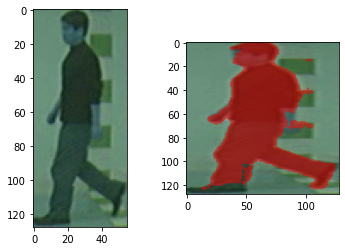

In [29]:
color = random_colors(1)
roi_resized = cv2.resize(roi, (width, height), cv2.INTER_LINEAR)
out = apply_mask(roi_resized, pred, color[0])
plt.subplot(121); plt.imshow(roi); 
plt.subplot(122); plt.imshow(out);

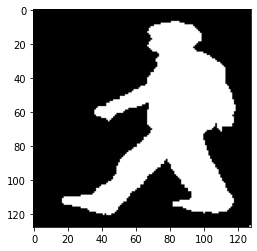

In [148]:
plt.imshow(pred[3,:,:,], 'gray')

In [154]:
np.uint(pred).shape

(65, 128, 128)

# ! unzip GaitDatasetB-silh.zip
!mkdir CASIA/
!mkdir CASIA/DatasetB
!mkdir CASIA/DatasetB/silhouettes
!mkdir GEI GEnI data_100_100
!mkdir CASIA/sil

In [1]:
import tarfile
from glob import glob
import shutil
import os

In [5]:
def create_dir(folder, force=True, verbose=False):
    '''   Create a directory if it doesn't exist  '''
    try:
        os.makedirs(folder)
        if verbose: print('Directory {} created succesfully.'.format(folder))   
    except:
        if force:
            if verbose: print('{} already exists. Creating a new one'.format(folder))
            shutil.rmtree(folder)
            os.makedirs(folder)
        else:
            if verbose: print('{} already exists.'.format(folder))
            pass

In [33]:
partA = 'DatasetB-1/silhouettes/'
partB = 'DatasetB-2/silhouettes/'
silhouettes_dir = 'silhouettes_Unet22K/'
# define the path of CASIA directory
CASIA_dir = '/home/israel/Downloads/CASIA/'

In [4]:
from glob import glob
for i in range(50, 125):
    part = partA if i<63 else partB
    if(i%10 == 0):
        print('Extracting Subject:'+str(i).zfill(3)+ '...')
    tf = tarfile.open(os.path.join(CASIA_dir, part, f'{str(i).zfill(3)}.tar.gz'))
    tf.extractall(os.path.join(CASIA_dir, silhouettes_dir))

Extracting Subject:050...
Extracting Subject:060...
Extracting Subject:070...
Extracting Subject:080...
Extracting Subject:090...
Extracting Subject:100...
Extracting Subject:110...
Extracting Subject:120...


## 2. FEATURE NORMALIZATION

In [13]:
import numpy as np
from os import listdir
import cv2
import os
from glob import glob
import time
import matplotlib.pyplot as plt

Let's define some functions to process the contours

In [14]:
def find_if_close(cnt1,cnt2):
    row1,row2 = cnt1.shape[0],cnt2.shape[0]
    for i in range(row1):
        for j in range(row2):
            dist = np.linalg.norm(cnt1[i]-cnt2[j])
            if abs(dist) < 40 :
                return True
            elif i==row1-1 and j==row2-1:
                return False


def joincontours(contours,thresh):
    LENGTH = len(contours)
    status = np.zeros((LENGTH,1))

    for i,cnt1 in enumerate(contours):
        x = i    
        if i != LENGTH-1:
            for j,cnt2 in enumerate(contours[i+1:]):
                x = x+1
                dist = find_if_close(cnt1,cnt2)
                if dist == True:
                    val = min(status[i],status[x])
                    status[x] = status[i] = val
                else:
                    if status[x]==status[i]:
                        status[x] = i+1

    unified = []
    maximum = int(status.max())+1
    for i in range(maximum):
        pos = np.where(status==i)[0]
        if pos.size != 0:
            cont = np.vstack(contours[i] for i in pos)
            hull = cv2.convexHull(cont)
            unified.append(hull)

    cv2.drawContours(thresh,unified,-1,255,-1)
    return thresh

In [15]:
from IPython.display import clear_output
import numpy as np
import cv2
import os
from os import listdir
from glob import glob
import time
import matplotlib.pyplot as plt


def GEI_generator(sil_file, size = 64,debug = False):
  lfiles = os.listdir(sil_file)
  lfiles.sort()
  stack_GEI = []
  if debug:
    plt.figure(figsize=(20,int(len(lfiles)/10)))
  for idimg, path in enumerate(lfiles):
    if debug: plt.subplot((len(lfiles)/15)+1,15, idimg+1)
    img = cv2.imread(sil_file+path,0)
    # Silhouette extraction
    contours1,_ = cv2.findContours(img.copy(),cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(img,contours1,-1,255,-1)

    if (len(contours1)>0):
      ncoun= np.concatenate(contours1)[:,0,:]
      x1, y1 = np.min(ncoun,axis=0)
      x2, y2 = np.max(ncoun,axis=0)
      silhouette = img[y1:y2,x1:x2]

      # Normalizae silhouette
      factor = size/max(silhouette.shape)
      height = round(factor*silhouette.shape[0])
      width = round(factor*silhouette.shape[1])
      if(height>width):
        nor_sil = cv2.resize(silhouette,(width,height))
#         print(nor_sil.shape)
        # We add a background of the shape size x size
        portion_body = 0.3                                                      # We take the upper part of the body to center the image and avoid the legs
        moments = cv2.moments(nor_sil[0:int(nor_sil.shape[0]*portion_body),])
        w = round(moments['m10']/moments['m00'])
        background = np.zeros((size, size))
        shift = round((size/2)-w)
#         print('center:',w,' shift:',shift)
        if(shift<0 or shift+nor_sil.shape[1]>size): shift = round((size-nor_sil.shape[1])/2)
        background[:,shift:nor_sil.shape[1]+shift] = nor_sil

        stack_GEI.append(background)
        if debug:
          plt.xticks([])
          plt.yticks([])
          plt.imshow(background,'gray')
          # plt.subplots_adjust(wspace=0.05, hspace=0.01)
  if stack_GEI == []:
    GEI = np.zeros((size, size))
    print('\tNo Files Found')
  else: 
    GEI = np.mean(np.array(stack_GEI),axis=0)
    
  return GEI, stack_GEI

In [37]:
GEI, stack = GEI_generator(rep_sil)

NameError: name 'rep_sil' is not defined

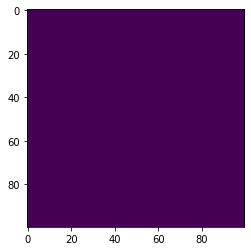

In [38]:
plt.imshow(GEI)

In [16]:
representation_dir = 'representations/'
conditions = np.array(['bg-01','bg-02','cl-01','cl-02','nm-01','nm-02','nm-03','nm-04','nm-05','nm-06'])
view = '090/'
size = 100
GEI_dir = 'GEI_UNet22K/'
create_dir(os.path.join(CASIA_dir, GEI_dir))
subjects = sorted(os.listdir(os.path.join(CASIA_dir, silhouettes_dir)))
count = 0
for subject in subjects:
    print('Sujeto :', subject)
    for condition in conditions:
#     directory_sub = os.path.join(CASIA_dir, representation_dir, subject);
#     if not os.path.exists(directory_sub):
#         os.makedirs(directory_sub)
#     for condition in conditions:
#     directory_condition = os.path.join(CASIA_dir, representation_dir, subject, condition)
#     if not os.path.exists(directory_condition):
#     os.makedirs(directory_condition)

        path = os.path.join(CASIA_dir, silhouettes_dir, subject, condition, view)
        save_path = os.path.join(CASIA_dir, GEI_dir, f'{subject}_{condition}_{view[:-1]}.png')
        GEI, _ = GEI_generator(path, size)
        GEI[int(size*0.12):int(size*0.68),:] = 0
        cv2.imwrite(save_path, GEI)

        if cv2.waitKey(1) & 0xff==27:
            break

cv2.destroyAllWindows()

Sujeto : 001
Sujeto : 002
Sujeto : 003
Sujeto : 004
Sujeto : 005
Sujeto : 006
Sujeto : 007
Sujeto : 008
Sujeto : 009
Sujeto : 010
Sujeto : 011
Sujeto : 012
Sujeto : 013
Sujeto : 014
Sujeto : 015
Sujeto : 016
Sujeto : 017
Sujeto : 018
Sujeto : 019
Sujeto : 020
Sujeto : 021
Sujeto : 022
Sujeto : 023
Sujeto : 024
Sujeto : 025
Sujeto : 026
Sujeto : 027
Sujeto : 028
Sujeto : 029
Sujeto : 030
Sujeto : 031
Sujeto : 032
Sujeto : 033
Sujeto : 034
Sujeto : 035
Sujeto : 036
Sujeto : 037
Sujeto : 038
Sujeto : 039
Sujeto : 040
Sujeto : 041
Sujeto : 042
Sujeto : 043
Sujeto : 044
Sujeto : 045
Sujeto : 046
Sujeto : 047
Sujeto : 048
Sujeto : 049
Sujeto : 050


In [17]:
save_path

'/home/israel/Downloads/CASIA/GEI_UNet22K/050_nm-06_090.png'

PREPROCESSING

In [18]:
import numpy as np
from numpy import ma
from os import listdir
import cv2
import os
from glob import glob
import time
# import skimage
# from skimage import transform

# Definomos la direccion de las imagenes
# data_base = 'CASIA'
# data_set = 'DatasetB' 
# directorio = 'silhouettes'	

train_ = np.array(['nm-01','nm-02','nm-03','nm-04'])
test_nm_ = np.array(['nm-05','nm-06'])
test_cl_ = np.array(['cl-01','cl-02'])
test_bg_ = np.array(['bg-01','bg-02'])
# view = '090'	
# formato = '.png'

# slash='/'
# location = data_base+slash+data_set+slash+directorio
# subject = np.array([])
# for cosa in range(1,125):
#     subject = np.append(subject,str(cosa).zfill(3))
# print(subject.shape)
# print(subject)
# # subject = subject[:60]

# rango = 1
# paso = 2
# size = 100

data = {}
data["train_"] = train_
data["test_nm_"] = test_nm_
data["test_cl_"] = test_cl_
data["test_bg_"] = test_bg_
# print(data['train_'])
for dset in data:
    print(dset, ':',data[dset])
    conditions = data[dset]
    matriz = []
    etiqueta = []
# 	matriz = np.zeros((len(subject)*len(condition)*rango,size*size))
# 	etiqueta = np.zeros((len(subject)*len(condition)*rango,1))
# 	c1 =0
    for subject in subjects:
        for condition in conditions:
            GEI_path = os.path.join(CASIA_dir, GEI_dir, f'{subject}_{condition}_{view[:-1]}.png')
            GEI = cv2.imread(GEI_path, 0)
            matriz.append(GEI.flatten())
            etiqueta.append(int(subject))
            
# 	for j in range(len(subject)):
# 		for i in range(len(condition)):
# 			# Definimos el nombre de la imagen
# 			slash='_'
# 			save_sil = 'GEI/'+data_base+slash+data_set+slash+directorio+slash+subject[j]+slash+condition[i]+slash+view+formato
# 			img = cv2.imread(save_sil,0)



# 			matriz[c1,:] = img.flatten()[np.newaxis]
# 			etiqueta[c1] = int(subject[j])

# 			c1 +=1
			# cv2.imshow('frame',imgr)
            if cv2.waitKey(1) & 0xff==27:
                break

    # matriz = matriz/255
    matriz = np.array(matriz)
    etiqueta = np.array(etiqueta)
    np.savetxt('data_100_100/'+dset+'data.dat', matriz)
    np.savetxt('data_100_100/'+dset+'target.dat', etiqueta)
    print(dset,'data.dat-> ',matriz.shape)
    print(dset,'data.dat-> ',etiqueta.shape)
    # print(etiqueta)
cv2.destroyAllWindows()

train_ : ['nm-01' 'nm-02' 'nm-03' 'nm-04']
train_ data.dat->  (200, 10000)
train_ data.dat->  (200,)
test_nm_ : ['nm-05' 'nm-06']
test_nm_ data.dat->  (100, 10000)
test_nm_ data.dat->  (100,)
test_cl_ : ['cl-01' 'cl-02']
test_cl_ data.dat->  (100, 10000)
test_cl_ data.dat->  (100,)
test_bg_ : ['bg-01' 'bg-02']
test_bg_ data.dat->  (100, 10000)
test_bg_ data.dat->  (100,)


In [19]:
import numpy as np
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import svm


def normalizacion(data):
	u = np.mean(data,axis=0)
	s = np.std(data,axis=0)
	data = (data - u)/s
	return (data,u,s)
def normalizacion2(data,u,s):
	data = (data - u) / s
	return data

# Cargamos la base de datos
if(0):
	carpeta = 'A/data/'
else:
	carpeta = 'data_100_100/'
trainX = np.loadtxt(carpeta+'train_data.dat')
print('Max: ',trainX.max(),' min: ',trainX.min())

# Escalamos los datos
scaler = StandardScaler()
scaler.fit(trainX)
trainX = scaler.transform(trainX)
# trainX,mean,st = normalizacion(trainX)


print('Entrenamiento data: ',trainX.shape)
print('Max: ',trainX.max(),' min: ',trainX.min())

trainY = np.loadtxt(carpeta+'train_target.dat')
print('Entrenamiento target: ',trainY.shape)

_ ,componentes_original = trainX.shape

# Aplicamos PCA
pre = 0.9999
pca = PCA(pre)
pca.fit(trainX)
componentes_PCA = pca.n_components_
print('Componentes Original : ',componentes_original,'\nComponentes PCA: ',componentes_PCA, '\nPreservando: ',pre*100)
trainX = pca.transform(trainX)

# lda = LinearDiscriminantAnalysis(n_components=60,solver='eigen')
# trainX = lda.fit(trainX, trainY).transform(trainX)

# Declaramos el modelo y lo ajustamos
# logisticRegr = LogisticRegression(solver = 'lbfgs',C=0.1,tol=0.0000001)
# logisticRegr = KNeighborsClassifier(n_neighbors=1)
# logisticRegr = svm.SVC()
logisticRegr = LinearDiscriminantAnalysis(solver = 'lsqr',shrinkage=0.2)
logisticRegr.fit(trainX, trainY)


# Calculamos su score
score = logisticRegr.score(trainX, trainY)
print('Dataset: Train',' shape test: ',trainX.shape,' correcto: ',np.round(score,4))
# Realizamos pruebas en los datasets de testeo
datasets = np.array(['test_nm_','test_bg_','test_cl_'])
for i in range(len(datasets)):
	testX = np.loadtxt(carpeta+datasets[i]+'data.dat')
	testX = scaler.transform(testX)
	# testX = normalizacion2(testX,mean,st)
	testX = pca.transform(testX)
	testY = np.loadtxt(carpeta+datasets[i]+'target.dat')
	
	# Calculamos su score
	score = logisticRegr.score(testX, testY)
	certeza = logisticRegr.predict(testX)

	# Mostramos la matriz de confusion
	# print(confusion_matrix(certeza,testY))
	print('Dataset: ',datasets[i],' shape test: ',testX.shape,' correcto: ',np.round(score,4))


# Guardamos el modelo entrenado
# from sklearn.externals import joblib
# joblib.dump(logisticRegr, 'LR.pkl') 
# joblib.dump(pca, 'pca.pkl') 
# joblib.dump(scaler, 'scaler.pkl') 

Max:  255.0  min:  0.0
Entrenamiento data:  (200, 10000)
Max:  14.106735979665936  min:  -10.120009833322896
Entrenamiento target:  (200,)
Componentes Original :  10000 
Componentes PCA:  197 
Preservando:  99.99
Dataset: Train  shape test:  (200, 197)  correcto:  1.0
Dataset:  test_nm_  shape test:  (100, 197)  correcto:  0.98
Dataset:  test_bg_  shape test:  (100, 197)  correcto:  0.84
Dataset:  test_cl_  shape test:  (100, 197)  correcto:  0.65


In [22]:
from pickle import dump

In [23]:
dump(scaler, open('CASIA_UNet22K_scaler.pkl', 'wb'))
dump(pca, open('CASIA_UNet22K_pca.pkl', 'wb'))
dump(logisticRegr, open('CASIA_UNet22K_model.pkl', 'wb'))

Lets join multiple subjects to test in the OAK-D

In [7]:
import cv2
import numpy as np
import os

In [19]:
partA = 'DatasetB-1/'
partB = 'DatasetB-2/silhouettes/'
silhouettes_dir = 'silhouettes/'
# define the path of CASIA directory
CASIA_dir = '/home/israel/Downloads/CASIA/'
videos_dir = 'video/'
view = '090'
conditions = ['nm-05', 'nm-06']
out_inf = None

In [36]:
cap = cv2.VideoCapture('/home/israel/Downloads/CASIA/DatasetB-1/video/001-nm-05-090.avi')
clip_name = 'nm_1-30_cond.avi'
codec = cv2.VideoWriter_fourcc(*'XVID')
fwidth = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
fheight = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))
out = cv2.VideoWriter(clip_name, codec, fps, (fwidth, fheight))

In [37]:
for subject in range(1, 30):
    for condition in conditions:
        part = partA if subject<63 else partB
        path = os.path.join(CASIA_dir, part, videos_dir, f'{str(subject).zfill(3)}-{condition}-{view}.avi')
        print(path)
        cap = cv2.VideoCapture(path)
        ret = True
        while(ret):
            ret, frame = cap.read()
            if ret:
                out.write(frame)
#                 cv2.imshow('out',frame)
                if cv2.waitKey(1) == ord('q'):
                    break
        white = (np.ones((fheight, fwidth, 3))*255).astype('uint8')
        for i in range(5):
            out.write(white)
        cap.release()
        cv2.destroyAllWindows()
out.release()   


/home/israel/Downloads/CASIA/DatasetB-1/video/001-nm-05-090.avi
/home/israel/Downloads/CASIA/DatasetB-1/video/001-nm-06-090.avi
/home/israel/Downloads/CASIA/DatasetB-1/video/002-nm-05-090.avi
/home/israel/Downloads/CASIA/DatasetB-1/video/002-nm-06-090.avi
/home/israel/Downloads/CASIA/DatasetB-1/video/003-nm-05-090.avi
/home/israel/Downloads/CASIA/DatasetB-1/video/003-nm-06-090.avi
/home/israel/Downloads/CASIA/DatasetB-1/video/004-nm-05-090.avi
/home/israel/Downloads/CASIA/DatasetB-1/video/004-nm-06-090.avi
/home/israel/Downloads/CASIA/DatasetB-1/video/005-nm-05-090.avi
/home/israel/Downloads/CASIA/DatasetB-1/video/005-nm-06-090.avi
/home/israel/Downloads/CASIA/DatasetB-1/video/006-nm-05-090.avi
/home/israel/Downloads/CASIA/DatasetB-1/video/006-nm-06-090.avi
/home/israel/Downloads/CASIA/DatasetB-1/video/007-nm-05-090.avi
/home/israel/Downloads/CASIA/DatasetB-1/video/007-nm-06-090.avi
/home/israel/Downloads/CASIA/DatasetB-1/video/008-nm-05-090.avi
/home/israel/Downloads/CASIA/DatasetB-1/

frame

In [78]:
frame.shape

(240, 320, 3)

In [11]:
white.shape

(240, 320, 3)

In [5]:
targets = []
for i in range(1,30):
    targets.append(i)
    targets.append(i)

In [51]:
oak_pred = [[57, 1, 1, 1], [77, 1, 1, 1], [81, 56, 17, 2, 2], [51, 51, 2, 2], [87, 3, 3, 3], [93, 3, 3, 3], [4, 4, 4, 4, 4], [14, 4, 4, 4, 4], [33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 123, 30, 57, 57, 57, 57, 57], [33, 33, 33, 48, 48, 83, 83, 83, 83, 83], [120, 124, 6], [86, 6, 6], [97, 7, 7], [7, 7, 7], [8, 8, 8, 8], [8, 8, 8, 8], [81, 9, 9, 9], [93, 67, 67, 67], [123, 123, 123, 123], [51, 51, 123, 123], [30, 73, 73, 11], [30, 11, 11, 11], [12, 12, 12], [12, 12, 12, 12], [93, 61, 93, 93, 93], [26, 99, 81, 28, 28], [14, 14, 14, 14, 14], [14, 14, 14, 14, 14], [34, 47, 47, 94], [30, 30, 117, 117], [65, 123, 123, 123], [123, 123, 123], [29, 17, 17, 17], [81, 17, 17, 17], [20, 44, 18], [30, 18, 18], [19, 19, 19], [110, 19, 66], [96, 96, 96, 96], [96, 96, 96], [21, 48, 48, 21], [21, 48, 48], [22, 22, 22, 22], [22, 22, 22, 22], [51, 33, 33, 33], [51, 33, 33, 33], [57, 24, 24, 24, 24], [26, 26, 57, 24, 24], [14, 93, 87, 25], [93, 25, 25, 25], [117, 30, 26, 26], [30, 26, 26, 26], [30, 30, 30, 30, 30], [96, 30, 30, 30], [101, 123, 123, 123, 123], [123, 123, 123, 123], [110, 29, 29, 29], [29, 29, 29, 29]]

In [54]:
oak_pred = [[1, 1, 1, 1], [63, 1, 1, 1], [99, 99, 84, 56, 99], [87, 2, 2, 2], [115, 93, 3, 3], [120, 38, 38, 3], [73, 51, 4, 4, 4], [73, 51, 4, 4, 4], [33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 123, 123, 123, 123, 123, 123, 123], [33, 33, 33, 88, 73, 73, 73, 73, 73, 73], [99, 35, 6], [105, 114, 6], [7, 7, 7], [97, 7, 7], [110, 110, 110, 8], [55, 110, 8, 8], [81, 9, 9, 9], [81, 38, 38, 38], [51, 51, 10, 10], [55, 110, 110, 110], [11, 11, 11, 11], [11, 11, 11, 11], [55, 12, 12], [55, 55, 12, 12], [26, 61, 61, 93, 93], [26, 99, 93, 28, 28], [87, 14, 14, 14, 14], [87, 14, 14, 14, 14], [34, 94, 94, 94], [30, 30, 73, 94], [65, 55, 99, 107], [61, 99, 56], [110, 38, 38, 17], [81, 99, 17, 17], [102, 18, 18], [30, 18, 18], [19, 19, 19], [81, 19, 6], [96, 96, 96, 96], [96, 96, 96], [82, 48, 48, 48], [51, 48, 48], [55, 22, 104, 100], [61, 61, 22, 104], [93, 93, 23, 23], [93, 93, 93, 23], [30, 26, 26, 24, 24], [30, 30, 26, 26, 24], [14, 93, 14, 56], [87, 98, 25, 25], [30, 26, 26, 26], [30, 26, 26, 26], [30, 30, 30, 30, 30], [30, 30, 30, 30], [101, 101, 28, 28, 28], [113, 28, 28, 28], [29, 29, 29, 14], [110, 110, 110, 14]]

In [3]:
oak_pred = [[1, 1, 1, 1], [77, 1, 1, 1], [35, 17, 17, 17, 56], [61, 99, 17, 2], [46, 46, 3, 3], [87, 38, 3, 3], [4, 4, 4, 4, 4], [4, 4, 4, 4, 4], [33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 65, 101, 38, 38, 56, 56, 56], [33, 33, 33, 88, 55, 83, 83, 83, 83, 83], [99, 38, 6], [38, 6, 6], [7, 7, 7], [100, 7, 7], [8, 8, 8, 8], [8, 8, 8, 8], [93, 9, 9, 9], [93, 67, 9, 9], [33, 46, 46, 46], [123, 46, 17, 10], [30, 73, 11, 11], [11, 11, 11, 11], [12, 12, 12], [55, 12, 12, 12], [93, 61, 61, 61, 93], [99, 99, 14, 28, 28], [14, 14, 14, 14, 14], [14, 14, 14, 14, 14], [34, 47, 47, 47], [30, 30, 47, 47], [104, 104, 17, 35], [61, 51, 56], [29, 17, 17, 17], [81, 17, 17, 17], [102, 100, 18], [30, 18, 18], [19, 19, 19], [110, 87, 72], [96, 96, 96, 96], [96, 96, 96], [21, 48, 48, 21], [21, 21, 21], [22, 22, 22, 22], [22, 22, 22, 22], [51, 93, 93, 93], [51, 51, 51, 51], [26, 24, 24, 24, 24], [26, 26, 57, 24, 24], [87, 87, 38, 25], [87, 98, 25, 25], [117, 117, 117, 26], [30, 26, 26, 26], [123, 123, 123, 30, 30], [96, 96, 30, 30], [123, 123, 28, 123, 123], [123, 123, 123, 123], [29, 29, 29, 29], [110, 29, 29, 29]]

In [6]:
# UNET 22K Fine 0.4
oak_pred = [[26, 1, 1, 1], [86, 1, 1, 1], [99, 17, 17, 56, 56], [87, 87, 17, 2], [46, 46, 38, 3], [87, 38, 38, 3], [73, 73, 4, 4, 4], [73, 73, 4, 4, 4], [33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 5, 30, 73, 73, 73, 73, 73], [33, 33, 33, 123, 73, 73, 123, 123, 123, 123], [73, 38, 6], [73, 6, 6], [99, 99, 7], [110, 7, 7], [55, 8, 8, 8], [55, 8, 8, 8], [73, 9, 9, 9], [93, 38, 38, 9], [123, 46, 46, 46], [123, 123, 105, 123], [30, 73, 73, 73], [30, 11, 11, 11], [55, 12, 12], [73, 55, 12, 12], [26, 61, 61, 93, 93], [26, 99, 14, 28, 28], [14, 14, 14, 14, 14], [57, 14, 14, 14, 14], [30, 30, 117, 30], [30, 30, 30, 117], [123, 123, 123, 123], [123, 123, 123], [110, 38, 38, 38], [14, 17, 17, 17], [30, 102, 18], [30, 102, 18], [19, 19, 56], [42, 73, 66], [96, 96, 96, 96], [96, 96, 96], [21, 48, 48, 48], [21, 48, 48], [99, 22, 99, 99], [22, 22, 104, 104], [51, 51, 51, 51], [51, 33, 51, 51], [30, 26, 26, 24, 24], [30, 73, 26, 57, 24], [14, 87, 38, 98], [87, 98, 40, 40], [30, 30, 73, 73], [30, 30, 30, 26], [96, 30, 30, 30, 30], [96, 30, 30, 30], [123, 123, 123, 123, 123], [51, 51, 51, 123], [42, 110, 29, 14], [73, 110, 110, 14]]

# UNET 22K Fine 0.3
oak_pred = [[26, 1, 1, 1], [26, 1, 1, 1], [99, 87, 87, 56, 56], [87, 87, 2, 2], [73, 93, 93, 3], [63, 87, 93, 3], [73, 73, 73, 4, 4], [73, 73, 4, 4, 4], [33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 5, 30, 30, 73, 73, 73, 73], [33, 33, 33, 48, 73, 73, 73, 73, 73, 73], [73, 124, 6], [73, 6, 6], [7, 7, 7], [110, 7, 7], [8, 8, 8, 8], [8, 8, 8, 8], [73, 9, 9, 9], [93, 67, 67, 67], [123, 123, 123, 123], [123, 123, 123, 123], [30, 11, 11, 11], [30, 11, 11, 11], [12, 12, 12], [73, 55, 12, 12], [26, 61, 61, 93, 93], [26, 26, 26, 28, 28], [14, 14, 14, 14, 14], [57, 14, 14, 14, 14], [30, 30, 30, 30], [30, 30, 30, 30], [123, 123, 123, 123], [123, 123, 123], [110, 38, 38, 17], [14, 17, 17, 17], [30, 102, 18], [30, 102, 18], [19, 19, 19], [42, 73, 66], [96, 96, 96, 96], [96, 96, 96], [21, 48, 48, 21], [21, 48, 48], [99, 22, 22, 22], [22, 22, 22, 22], [33, 33, 33, 33], [33, 33, 33, 33], [30, 30, 26, 24, 24], [30, 73, 73, 24, 24], [14, 87, 87, 25], [87, 98, 25, 25], [30, 30, 117, 117], [30, 30, 30, 26], [96, 30, 30, 30, 96], [96, 96, 30, 30], [123, 123, 123, 123, 123], [123, 33, 33, 123], [42, 110, 29, 14], [73, 110, 110, 14]]

In [10]:
# UNET 59K Fine 0.4
oak_pred = [[26, 1, 1, 1], [26, 1, 1, 1], [110, 14, 87, 14, 113], [42, 99, 99, 2], [73, 38, 38, 38], [73, 14, 38, 57], [30, 73, 73, 73, 73], [73, 73, 73, 73, 73], [33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 5, 30, 30, 73, 73, 73, 73], [33, 33, 33, 48, 48, 73, 73, 73, 73, 73], [73, 73, 6], [73, 6, 6], [7, 7, 7], [7, 7, 7], [30, 55, 110, 8], [73, 55, 8, 8], [73, 73, 73, 9], [93, 14, 67, 67], [73, 73, 55, 73], [110, 110, 110, 110], [30, 73, 73, 73], [30, 11, 11, 73], [55, 55, 12], [73, 55, 55, 55], [26, 26, 93, 93, 93], [26, 26, 14, 81, 28], [14, 14, 14, 14, 14], [73, 14, 14, 14, 14], [86, 86, 1, 94], [73, 73, 73, 73], [73, 73, 73, 107], [55, 55, 42], [110, 17, 17, 17], [14, 14, 14, 17], [84, 84, 18], [81, 18, 18], [87, 19, 19], [30, 73, 73], [30, 30, 30, 30], [30, 30, 30], [21, 123, 48, 48], [48, 48, 48], [55, 55, 55, 100], [22, 110, 110, 110], [51, 93, 93, 93], [30, 51, 51, 116], [101, 26, 26, 57, 24], [30, 57, 57, 57, 57], [14, 93, 14, 25], [41, 87, 25, 25], [30, 30, 30, 26], [30, 26, 26, 26], [30, 26, 27, 27, 27], [30, 26, 93, 27], [30, 28, 28, 28, 28], [30, 26, 28, 28], [73, 73, 110, 14], [73, 110, 14, 14]]

# UNET 59K Fine 0.5
# oak_pred = [[30, 1, 1, 1], [26, 1, 1, 1], [110, 87, 87, 113, 113], [42, 87, 2, 2], [42, 38, 93, 93], [73, 42, 93, 57], [30, 73, 73, 73, 73], [73, 73, 73, 73, 73], [33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 5, 30, 30, 30, 30, 30, 30], [33, 33, 33, 48, 73, 73, 73, 73, 73, 73], [73, 73, 6], [73, 6, 6], [7, 7, 7], [7, 7, 7], [55, 110, 8, 8], [73, 55, 8, 8], [73, 73, 73, 9], [26, 67, 67, 67], [73, 55, 110, 42], [55, 110, 110, 110], [30, 11, 11, 11], [30, 11, 11, 11], [55, 12, 12], [73, 55, 55, 55], [26, 26, 26, 93, 28], [26, 26, 26, 94, 28], [87, 14, 14, 14, 14], [30, 14, 14, 14, 14], [117, 117, 117, 94], [73, 73, 73, 73], [73, 99, 99, 107], [30, 55, 41], [110, 110, 17, 17], [81, 110, 14, 17], [100, 18, 18], [86, 18, 18], [26, 19, 19], [30, 73, 73], [30, 30, 30, 30], [30, 30, 30], [117, 123, 48, 48], [55, 48, 48], [55, 55, 110, 100], [110, 22, 110, 110], [51, 51, 23, 23], [33, 33, 33, 51], [101, 26, 26, 24, 24], [30, 30, 26, 57, 24], [14, 93, 14, 113], [41, 93, 25, 25], [30, 30, 30, 30], [30, 30, 30, 26], [30, 26, 26, 94, 71], [30, 26, 41, 41], [30, 101, 28, 28, 28], [26, 28, 28, 28], [73, 73, 110, 14], [73, 73, 110, 14]]


In [11]:
acc = 0
corrects = 0
samples = len(targets)
for target, pred in zip(targets, oak_pred):
    if (target in pred):
        corrects +=1
print(corrects/samples)

0.5344827586206896
